# PNAS paper submission analysis

Analysing the wind characteristics of streaked shearwaters as they approach foraging points allows us to examine what conditions the birds travel in throughout foraging trips. 

## Previous study

In the most similar previous study ([Nevitt et al., 2008](https://www.pnas.org/content/105/12/4576)) investigating similar phenomena, the tracks of albatross approaching foraging points were examined and classified by their characteristics (in 4 groups: Direct, Turn, Zigzag, and Circle):

<p align="center">
   <img src=https://www.pnas.org/cms/10.1073/pnas.0709047105/asset/eb810a4f-38f4-4a23-beee-eb585774c043/assets/graphic/zpq0080896790001.jpeg alt="Albatross tracks approaching foraging" width="400">
</p>

And the histograms of relative wind bearings were examined for those categories:

 <p align="center">
    <img src=https://www.pnas.org/cms/10.1073/pnas.0709047105/asset/7d4e5b13-0f76-4fc1-b230-f77569c6a300/assets/graphic/zpq0080896790002.jpeg alt="Relative wind histograms" width="400">
 </p>
<!-- 
<p align="center>
   <img src= alt="Relative wind histograms">
</p> -->

This study used recordings of wandering albatross with GPS and stomach temperature transmitters. Foraging points were estimates as periods with rapid drops in stomach temperature, and surface landings taken from times when birds moved at under 2.8 m/s. Wind directions and speeds from all touchdown points were estimated using QuikSCAT daily level 3 gridded ocean wind vectors. This data comes from the SeaWinds scatterometer and records wind vector fields twice daily. Wind values cannot be produced for locations within 30km of land/ice. Backscatter recorded by the satellite is then processed through a Ku-band geophysical model function which derives surface wind speeds and direction. Rain contamination can be an issue due to difficulty in separating the backscatter effect of wind vs rain. The level value refers to the processing level of the data, starting at 0 (raw) through to 3 or 4.

In [1]:
using DataFrames, CSV, RCall, Geodesy, Dates, Statistics, Glob, CategoricalArrays, DSP, StatsPlots
using Plots; theme(:dark)

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for LogExpFunctions [2ab3a3ac-af41-5b50-aa03-7779005ae688]
│   exception = Required dependency DocStringExtensions [ffbed154-4ef7-542d-bbb7-c09d3a79fcae] failed to load from a cache file.
└ @ Base loading.jl:1132


┌ Warning: Module LogExpFunctions with build ID 209797101843313 is missing from the cache.
│ This may mean LogExpFunctions [2ab3a3ac-af41-5b50-aa03-7779005ae688] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module LogExpFunctions with build ID 209797101843313 is missing from the cache.
│ This may mean LogExpFunctions [2ab3a3ac-af41-5b50-aa03-7779005ae688] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module LogExpFunctions with build ID 209797101843313 is missing from the cache.
│ This may mean LogExpFunctions [2ab3a3ac-af41-5b50-aa03-7779005ae688] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module SpecialFunctions with build ID 209802262633695 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module SpecialFunctions with build ID 209802262633695 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module SpecialFunctions with build ID 209802262633695 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: The call to compilecache failed to create a usable precompiled cache file for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
│   exception = ErrorException("Required dependency StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c] failed to load from a cache file.")
└ @ Base loading.jl:1132


LoadError: LoadError: InitError: Could not find library /usr/local/Cellar/r/4.1.2/lib/R/lib/libR.dylib. Make sure that R shared library exists.
during initialization of module RCall
in expression starting at /Users/aran/.julia/packages/RCall/6kphM/src/RCall.jl:2

In [2]:
# RECURSIVE FILE SEARCH
function rdir(dir::AbstractString, pat::AbstractString)
    result = String[]
    for (root, dirs, files) in walkdir(dir)
        append!(result, filter!(f -> occursin(Regex(pat), f), joinpath.(root, files)))
    end
    return result[occursin.(Regex(pat), result)]
end
# DATETIME SETTING FUNCTION FOR AVAILABLE DATEFORMATS
function robust_DateTime_parse(str)
    if any(occursin.(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],str))
        DateTime(str,dateformat"d-u-y H:M:S.s")
    elseif any(isequal('-'), str)
        DateTime(str, dateformat"y-m-d H:M:S")
    else
        DateTime(str, dateformat"d/m/y H:M:S.s")
    end
end
# FUNCTION FOR READING IN FORAGING AND WIND DATASETS
function readDat(dataLocation::String, IDpattern::String, AndWind::Bool, colnames::Vector{Symbol}, header::Vector{Int64}, year::Vector{Int64})

    #=
    dataLocation:           Placement search for recursive file searcg
    IDPattern:              Pattern to extract year ID patterns
    colnames:               Array of column name symbols (two arrays required if wind requested
    header:                 Number of header rows (two values required if wind requested)
    year:                   Select year for data search
    =#

    if length(year) == 1
        year = [year]
    end
    # find forageGPS files
    forFiles = rdir(dataLocation, "(?=" * join(string.(year), "Shearwater|") * "Shearwater)"* ".*(?=BehaviourDetection)" * ".*(?=PredictedForage)" * ".*(?=ForageGPS.txt)")
    # isolate the unique datasets (year_tagID)
    yrIDs = unique(getindex.(match.(r"(\d+)Shearwater.*",forFiles),1) .* "_" .* getindex.(match.(Regex(IDpattern),forFiles),1))

    # preallocate output
    ForRet = [DataFrame() for _ in 1:length(yrIDs)]
    # repeat for wind if desired
    if AndWind == true
        wFiles = rdir.(dataLocation,"(?=".*join(string.(year), "Shearwater|").*"Shearwater).*(?=MinDat).*.csv")
        WindRet = [DataFrame() for _ in 1:length(yrIDs)]
    end
    # read in data
    for tg in 1:length(ForRet)
        fFiles = forFiles[occursin.(yrIDs[tg][1:4] * "Shearwater",forFiles) .& occursin.(Regex("[\\\\|/]" * "(?=" * yrIDs[tg][6:end] * ")"),forFiles)]
        for file in fFiles
            append!(ForRet[tg], hcat(CSV.read(file, DataFrame, header = header[1]), repeat([yrIDs[tg]], nrow(CSV.read(file, DataFrame, header = header[1])))), cols = :union)
        end
        rename!(ForRet[tg], colnames)
        if AndWind == true
            windFiles = wFiles[occursin.(yrIDs[tg][1:4] * "Shearwater",wFiles) .& occursin.(Regex("[\\\\|/]" * "(?=" * yrIDs[tg][6:end] * ")"),wFiles)]
            for file in windFiles
                append!(WindRet[tg], hcat(CSV.read(file, DataFrame, header = header[2]), repeat([yrIDs[tg]], nrow(CSV.read(file, DataFrame, header = header[2])))), cols = :union)
            end
            rename!(WindRet[tg], [:DT,:lat,:lon,:head,:X,:Y,:yrID])
        end
        # assign datetime
        ForRet[tg].DT = robust_DateTime_parse.(ForRet[tg].DT)
        if AndWind == true
            WindRet[tg].DT = robust_DateTime_parse.(WindRet[tg].DT)
        end
    end
    return ForRet, WindRet
end
# file locations for foraging and wind estimates
if Sys.iswindows()
    dataloc = "E:/My Drive/PhD/Data/"
else
    dataloc = "/Volumes/GoogleDrive-112399531131798335686/My Drive/PhD/Data/"
end
# # bring in FORAGING AND GPS DATA and WIND DATA (remove wind data by setting true to false)
fDat,wDat = readDat(dataloc,".*PredictedForage[\\\\|/](.*)_S.*-20.*",true,[:DT,:lat,:lon,:forage,:yrID],[1,0],[2018,2019]);

LoadError: LoadError: UndefVarError: @dateformat_str not defined
in expression starting at /Users/aran/Documents/GitHub/Olfactory/Julia/WindManuscript/ManuscriptAnalysis.ipynb:12

## Travel characteristics

Once the data is read in, the distances travelled and speeds between consecutive GPS points are calculated. I also calculate the linearity over a 51 minute sliding window (the same duration as the wind estimation method). This calculation is as follows:

$
\begin{align}
l = \frac{\sum_{t-\frac{t_{win}}{2}}^{t+\frac{t_{win}}{2}}{d_T}}{d_{direct}}
\end{align}
$

where $d_T$ is the distance travelled by the bird, $t_{win}$ is the time window (51 minutes), and $d_{direct}$ is the direct distance between the bird's positions at $t-\frac{t_{win}}{2}$ and $t+\frac{t_{win}}{2}$.

In [3]:
# add distance (m) and speed (kph) values
function dist(lat,lon)
    ll = LLA.(lat,lon)
    utmz = UTMZfromLLA(wgs84)
    return sqrt.(diff((p->p.x).(utmz.(ll))).^2 + diff((p->p.y).(utmz.(ll))).^2)
end
function speed(dt,lat,lon)
    tdiff = Dates.value.(Second.(diff(dt)))
    spTrav = (dist(lat,lon)./tdiff).*3.6
    return spTrav
end

# find the nearest time (index)
function findNearest(dt, time)
    argmin(abs.(dt .- time))
end
# calculate linearity
function linearity(dt,lat,lon,distance,twindow)
    out = Array{Float64}(undef,length(dt))
    for b = 1:findNearest(dt,(dt[end] - Second(twindow*60/2)))
        nextPoint = findNearest(dt, dt[b] + (Second(60*twindow/2)))
        prevPoint = findNearest(dt, dt[b] - (Second((twindow*60)/2)))
        if abs(dt[nextPoint] - (dt[b] + Second(twindow*60/2))) < Minute(1)
            out[b] = dist([lat[prevPoint],lat[nextPoint]],[lon[prevPoint],lon[nextPoint]])[1]/sum(distance[prevPoint:nextPoint])
        else
            out[b] = NaN
            
        end
    end
    return out
end

for x in fDat
    insertcols!(x, ncol(x) + 1, :distTrav => [dist(x.lat,x.lon);NaN])
    insertcols!(x, ncol(x) + 1, :spTrav => [speed(x.DT,x.lat,x.lon);NaN])
    insertcols!(x, ncol(x) + 1, :lin => linearity(x.DT,x.lat,x.lon,x.distTrav,51))
end

## Example linearity plot of one bird track

Colour denotes the linearity of the track on a scale of 1 (straight) to 0 (theoretically never approaching end).

In [ ]:
plot(fDat[6].lon,
    fDat[6].lat,
    color=:greens,
    label="",
    line_z=fDat[6].linearity,
    colorbar_title="Linearity (5 mins)",
    xlabel="Lon",
    ylabel="Lat")

In [ ]:
# assign data to the wind data
df = vcat(fDat...)
for wf in wDat
    wf.timeFP = repeat([NaN],nrow(wf))
    wf.distFP = repeat([NaN],nrow(wf))
    wf.speed = repeat([NaN],nrow(wf))
    wf.linearity = repeat([NaN],nrow(wf))
    for b = 1:nrow(wf)
        if any((df.DT .> wf.DT[b]) .& (df.forage .== 1) .& (df.yrID .== wf.yrID[b]))
            nxtFor = findfirst((df.DT .> wf.DT[b]) .& (df.forage .== 1) .& (df.yrID .== wf.yrID[b]))
            wf.timeFP[b] = Dates.value(Second(df.DT[nxtFor] - wf.DT[b]))
            wf.distFP[b] = dist(wf.lat[b],wf.lon[b],df.lat[nxtFor],df.lon[nxtFor])
            wf.speed[b] = mean(df.spTrav[(df.DT .> (wf.DT[b] - Second((5*60)/2))) .& (df.DT .< (wf.DT[b] + Second((5*60)/2))) .& (df.yrID .== wf.yrID[b])])
            wf.linearity[b] = mean(df.linearity[(df.DT .> (wf.DT[b] - Second((5*60)/2))) .& (df.DT .< (wf.DT[b] + Second((5*60)/2))) .& (df.yrID .== wf.yrID[b])])
        else
            break
        end
    end
end
# add foraging number to foraging data
function forNo(df)
    forageNo = repeat([NaN],nrow(df))
    forEd = findall(diff(df.forage) .== -1)
    if df.forage[1] == 1
        append!(forEd,nrow(df))
    end
    for b = 1:length(forEd)
        if b == 1
            forageNo[1:forEd[b]] .= Int(b)
        else
            forageNo[(forEd[b-1]+1):forEd[b]] .= Int(b)
        end
    end
    return forageNo
end
[insertcols!(df,ncol(df)+1, :forNo => forNo(df)) for df in fDat]
# add foraging number to wind estimates
function importForNo(df,wf)
    forNo = repeat([NaN],nrow(wf))
    for b = 1:nrow(wf)
        forNo[b] = df.forNo[findNearest(df.DT,wf.DT[b])]
    end
    return forNo
end
[insertcols!(wDat[b],ncol(wDat[b])+1, :forNo => importForNo(fDat[b],wDat[b])) for b in 1:length(fDat)];

## Binning data

Data from the GPS and foraging information are transferred to the estimated wind dataset. These include:
* Time and distance to the next foraging point
* Mean speed over 5 mins
* Mean linearity over 5 mins
To examine the trends in wind use as birds approach foraging points, distance to the next foraging point is binned.

In [ ]:
# ROUND TO NEAREST n
function roundNearest(x::Float64,n::Float64)
    round(x/n)*n
end

# BIN VALUES x INTO bins
function bin(x::Float64, bins::AbstractArray)
    pos = findlast(x .> bins)
    if !isnothing(pos)
        if bins[pos] == maximum(bins)
            out = string(maximum(bins)) * "+"
        else 
            out = string(bins[pos]) * " - " * string(bins[pos + 1])
        end
    else 
        out = missing
    end
    return out
end

bins = [0:10:roundNearest(maximum(vcat(wDat...).distFP[isnan.(vcat(wDat...).distFP) .== false]/1000),10.0);]
[insertcols!(wf,ncol(wf)+1, :distBin =>  bin.(wf.distFP./1000, Ref(bins))) for wf in wDat];


## Calculate relative wind headings

The wind estimation method provide an X and Y component of wind vector. The relative wind heading ($rwh$) is given by $rwh = \arctan{(Y,X)}$. Wind speed is calculated as $w_s = \sqrt{X^2 + Y^2}$.

In [ ]:
# calculate relative wind heading
function rwh(head,x,y)
    rwh = head - atan(y,x)
    if rwh < -pi
        rwh = rwh + (2*pi)
    elseif rwh > pi
        rwh = rwh - (2*pi)
    end
    return rwh
end
# align relative wind heading so 0 is headwind
function align(rwh)
    aligned = rwh + pi
    if aligned > pi
        aligned = aligned - (2*pi)
    end
    return aligned
end

[insertcols!(wf, ncol(wf)+1, :rwh => rwh.(wf.head,wf.X,wf.Y)) for wf in wDat];
[insertcols!(wf, ncol(wf)+1, :aligned => align.(wf.rwh)) for wf in wDat];

# for wf in wDat
#     select!(wf,Not([:rwh,:aligned]))
# end

In [ ]:
## Trip length information

As streaked shearwaters perform short and long foraging trips, an interesting factor we can examine would be the difference in foraging search behaviour between short trips, likely to areas well-known to previous breeders, and long trips, which would require the bird to be able to direct themselves over longer distances. With larger maximum foraging distances, the potential search area is much greater and so directing travel is more important. Similarly, over a shorter distance, use of visual cues is more likely and feasible. Therefore, we would expect to see a difference in the search behaviour across long and short foraging trips.

Therefore, we must first define long and short foraging trips. We take short days to be $<2$ days, as in [Matsumoto et al. 2012](https://www.jstage.jst.go.jp/article/osj/11/1/11_9/_article/-char/ja/). We may be able to determine the number of days in a foraging trip by using a similar method to [Shiomi et al. 2012](https://www.sciencedirect.com/science/article/abs/pii/S0003347211005021) to distinguish days, but for now we'll just use trips as judged by plotting tracks.

In [ ]:
# take mean approach speed over each hour 
# function AveApSp(dt,lat,lon,t)
#     out = Float64[]
#     try
#         out = mean(dist.(Ref(39.402289),Ref(141.998165),lat[t .<= dt .< (t + Dates.Hour(1))],lon[t .<= dt .< (t + Dates.Hour(1))]))        
#     catch
#         out = NaN
#     end
#     return out
# end
# function numTrips(dt,lat,lon)
#     appSp = AveApSp.(Ref(dt),Ref(lat),Ref(lon),dt)
#     chgPts = cat(dims=1,1,findall(appSp./1000 .> 2),length(dt))
#     out = cat(dims=1, [repeat(x,chgPts[x+1] - x)])
#     out = Vector{Float64}(undef,length(dt))
#     for b in 1:(length(chgPts) - 1)
#         out[chgPts[b]:chgPts[b + 1]] .= b
#     end
#     return out
# end

# [insertcols!(wf, ncol(wf)+1, :tripN => numTrips(wf.DT,wf.lat,wf.lon)) for wf in fDat];

tripLengths = Dict("2018_10" => [1,4,1],
    "2018_11" => [1,3,1,1],
    "2018_1" => [2,5,1,4],
    "2018_2017-9" => [1,4],
    "2018_3" => [3,1,4,1,1,1],
    "2018_4" => [3,1,6],
    "2018_5" => [8,1],
    "2018_6" => [4,5],
    "2018_7" => [2,5,1,1,2],
    "2018_8" => [3,1,5,1],
    "2018_9" => [2,1,4,2],
    "2019_1" => [1,1,1,1],
    "2019_2018-01" => [1,1,1,1,2],
    "2019_2018-03" => [1,4],
    "2019_2018-04" => [1,2,1,1],
    "2019_2018-05" => [1,4],
    "2019_2" => [1,3],
    "2019_3" => [1,1,1,1,2],
    "2019_4" => [1,1,1,2],
    "2019_5" => [1,1,3])

function tripNL(df::DataFrame,trLengths::Dict)
    tripN = Vector{Int}(undef,nrow(df))
    tripL = Vector{Int}(undef,nrow(df))
    yrid = df.yrID[1]
    trips = trLengths[yrid]
    tripEnds = cumsum(trips)
    tripStarts = cat(dims=1,1,tripEnds[1:end-1] .+ 1)
    tagDates = unique(Dates.Date.(df.DT))
    tripEnds[end] = minimum([length(tagDates),tripEnds[end]])
    for x = 1:length(tripEnds)
        tripN[tagDates[tripStarts[x]] .<= Dates.Date.(df.DT) .<= tagDates[tripEnds[x]]] .= Int(x)
        tripL[tagDates[tripStarts[x]] .<= Dates.Date.(df.DT) .<= tagDates[tripEnds[x]]] .= Int(trips[x])
    end
    return tripN,tripL
end
for df in fDat
    tripNo,tripLe = tripNL(df,tripLengths)
    insertcols!(df,:tripN => tripNo, :tripL => tripLe)
end
# for df in fDat
#     select!(df,Not(:tripN))
#     select!(df,Not(:tripL))
# end
# transfer to wind data
for wf in 1:length(wDat)
    wDat[wf].tripN = Vector{Int}(undef,nrow(wDat[wf]))
    wDat[wf].tripL = Vector{Int}(undef,nrow(wDat[wf]))
    for x in 1:nrow(wDat[wf])
        wDat[wf].tripN[x] = fDat[wf].tripN[findNearest(wDat[wf].DT[x],fDat[wf].DT)]
        wDat[wf].tripL[x] = fDat[wf].tripL[findNearest(wDat[wf].DT[x],fDat[wf].DT)]
    end
end

In [ ]:
function movingaverage(X::Vector,numofele::Int)
    BackDelta = div(numofele,2) 
    ForwardDelta = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    len = length(X)
    Y = similar(X)
    for n = 1:len
        lo = max(1,n - BackDelta)
        hi = min(len,n + ForwardDelta)
        Y[n] = mean(X[lo:hi])
    end
    return Y
end

# pks,vals = findmaxima(movingaverage(appSp./1000,10))
# pks,proms = peakproms(pks,movingaverage(appSp./1000,10))

# plot(fDat[2].DT,movingaverage(appSp./1000,10))
# plot!(fDat[2].DT[pks],movingaverage(appSp./1000,10)[pks]./1000,seriestype=:scatter)

## GAM modelling

GAMs within R have smoothing terms that can 

Distance to next foraging point ~ relative wind heading + speed + linearity

## Hidden Markov Model method

Previous testing of using a circular response variable in a GAM setup showed that it was unlikely to work well. However, another option would be a Hidden Markov Model (HMM), specifically using the `momentuHMM` package in the `R` language.

This package is written specifically for animal movement and as such contains a number of functions specific for the issues typically raised in animal telemetry research. One of these issues is temporal irregularities in data collection, either through lack of connection to satellites or through measurement error. This issue was raised in a [previous study](https://link.springer.com/article/10.1007/s13253-017-0285-6) by B. McClintock (one of the authors of the `momentuHMM` package).

There are a few potential solutions listed within the `momentuHMM` package notes, using the `MIfitHMM`, `MIpool`, and `cawlWrap` functions. `cawlWrap` fits a continuous-time correlated random walk to the data to predict regularly sampled data. This would not help the wind data issue as estimated wind values would not be predicted and so would not reliably contain the required information.

The `MIfitHMM` "fits a user-defined HMM to $m$ inputted data sets". This function can be used to analyse $m$ `momentuHMMData` generated by the user. In this case, we can take each continuous wind estimation period, convert each into a `momentuHMMData` object, then run `MIfitHMM` on that list. The `MIpool` function calculates pooled estimates, standard errors, and confidence intervals.

In [195]:
wDatAll = dropmissing(vcat(wDat...))
wDatAll.aligned[wDatAll.aligned .> pi] = wDatAll.aligned[wDatAll.aligned .> pi] .- 2*pi
wDatAll.distBin = categorical(wDatAll.distBin)
# @df wDatAll[wD`atAll.distFP .< (100*1000),:] density(:aligned, group = :distBin, legend = :topleft)
# wDatAll = wDatAll[wDatAll.distFP .< 100*1000,:]

@df wDatAll[wDatAll.distFP .< 100*1000,:] density(:aligned, group = :distBin, :tripL, title = "Relative wind use on FP approach", 
    xlabel = "Relative wind heading")
xticks!([-pi,-pi/2,0,pi/2,pi],["Tailwind","Sidewind","Headwind","Sidewind","Tailwind"])

ArgumentError: ArgumentError: column name :aligned not found in the data frame

## Linearity vs approach wind use

As birds approach FPs, we can look at the relative linearity of their flights. 

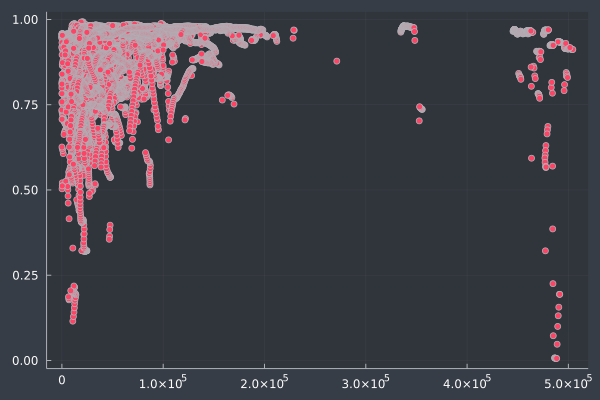

In [12]:
scatter(vcat(wDat...).distFP,vcat(wDat...).linearity,label="")

## Foraging duration vs wind use

Inclusion of foraging duration as metric of flight style and wind use

## Flapping rates during flight

Using FFT, periodograms can be calculated for the dynamic dorsoventral signal. From there, peak frequencies can track the flapping frequency of the animal during period of wind estimation. 

In [224]:
# FLAPPING RATES

yrIDs = [df.yrID[1] for df in fDat]

function readinAxy(yrID::String)
    file=rdir(dataloc,"(?=" * yrID[1:4] * "Shearwater).*AxyTrek.*(?=" * yrID[6:end] * "_...csv)")
    dat = CSV.read(file[1],DataFrame,header=1,select=[:TagID,:Timestamp,:X,:Y,:Z]  
    )
    # remove missing rows
    dat = dropmissing(dat,:Timestamp)
    dat.Timestamp = DateTime.(dat.Timestamp,dateformat"d/m/y H:M:S.s") .+ Hour(9)
    return dat
end

# accDat = readinAxy(yrIDs[1])

┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 22275002. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 25517202. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 26172002. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 9459752. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 25763252. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 25316252. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 26205752. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 22032002. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 24082502. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 26630252. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 9459752. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


ArgumentError: ArgumentError: column name :Timestamp not found in the data frame

In [227]:
tst = readinAxy(yrIDs[1])

┌ Warning: thread = 1 warning: only found 1 / 15 columns around data row: 22275002. Filling remaining columns with `missing`
└ @ CSV C:\Users\arang\.julia\packages\CSV\Zl2ww\src\file.jl:612


,TagID,Timestamp,X,Y,Z
,String,DateTime,Float64?,Float64?,Float64?
1,10_S1,2018-09-01T14:02:00,-0.031,0.188,0.469
2,10_S1,2018-09-01T14:02:00.040,-0.062,0.281,0.688
3,10_S1,2018-09-01T14:02:00.080,-0.062,0.312,0.812
4,10_S1,2018-09-01T14:02:00.120,-0.062,0.344,0.875
5,10_S1,2018-09-01T14:02:00.160,-0.031,0.312,0.906
6,10_S1,2018-09-01T14:02:00.200,-0.062,0.344,0.906
7,10_S1,2018-09-01T14:02:00.240,-0.031,0.344,0.938
8,10_S1,2018-09-01T14:02:00.280,-0.031,0.312,0.906
9,10_S1,2018-09-01T14:02:00.320,-0.031,0.281,0.938


In [248]:
# # tst = tst[1:findlast(tst.Timestamp .<= fDat[1].DT[end]),:]
responsetype = Lowpass(1.5; fs=25)
designmethod = Butterworth(4)
histogram(filt(digitalfilter(responsetype,designmethod),tst.X))


StackOverflowError: StackOverflowError: